In [1]:
!pip install imageio
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 6.4 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 7.0 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import os, random, json, PIL, shutil, re, imageio, glob
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import ImageDraw
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.keras import Model, losses, optimizers, applications
from tensorflow.keras.callbacks import Callback


def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    
SEED = 0
seed_everything(SEED)

D0622 19:31:51.619713671      14 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D0622 19:31:51.619748637      14 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D0622 19:31:51.619752355      14 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D0622 19:31:51.619755171      14 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D0622 19:31:51.619757621      14 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D0622 19:31:51.619760378      14 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D0622 19:31:51.619763051      14 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D0622 19:31:51.

In [17]:
from PIL import Image, ImageDraw

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(f'Running on TPU {tpu.master()}')
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()


REPLICAS = strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE
print(f'REPLICAS: {REPLICAS}')

Running on TPU 
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


REPLICAS: 8


In [20]:
HEIGHT_DS = 512
WIDTH_DS = 512
HEIGHT = 256
WIDTH = 256
HEIGHT_RESIZE = 256
WIDTH_RESIZE = 256
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 100
TRANSFORMER_BLOCKS = 4
GENERATOR_LR = 2e-4
DISCRIMINATOR_LR = 2e-4

In [5]:
disease_folder ="/kaggle/input/lemonleafclassification/lemon/Diseased Lemon"
healthy_folder = "/kaggle/input/lemonleafclassification/lemon/Regular Lemon"
test_folder = "/kaggle/input/lemonleafclassification/lemon/Test"

disease_filenames = glob.glob(os.path.join(disease_folder, "*.JPG"))
healthy_filenames = glob.glob(os.path.join(healthy_folder, "*.JPG"))
diseased_lemon_count = len(os.listdir(disease_folder))
healthy_lemon_count = len(os.listdir(healthy_folder))


print(f"Diseased lemon: {diseased_lemon_count} samples")
print(f"Healthy lemon: {healthy_lemon_count} samples")


Diseased lemon: 107 samples
Healthy lemon: 126 samples


In [6]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if p_spatial > .75:
        image = tf.image.transpose(image)

    if p_rotate > .75:
        image = tf.image.rot90(image, k=3)
    elif p_rotate > .5:
        image = tf.image.rot90(image, k=2) 
    elif p_rotate > .25:
        image = tf.image.rot90(image, k=1) 
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower=.7, upper=1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower=.8, upper=1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta=.1)
        
    image = tf.image.resize(image, [HEIGHT_RESIZE, WIDTH_RESIZE])
    
    return image

In [7]:
def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
 
    return (img / 127.5) - 1.0

def decode_image(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_jpeg(image, channels=CHANNELS)
    image = tf.image.resize(image, [HEIGHT, WIDTH])
    image = tf.reshape(image, [HEIGHT, WIDTH, CHANNELS])
    return image

def load_dataset(image_folder):
    image_paths = glob.glob(os.path.join(image_folder, "*.JPG"))
    print(f"Loaded {len(image_paths)} images from {image_folder}")
    labels = [0] * len(image_paths)  
    return image_paths, labels

def get_dataset(image_folder, augment=None, repeat=True, shuffle=True, batch_size=1):
   
    image_paths, _ = load_dataset(image_folder)
    
    dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    dataset = dataset.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
    if repeat:
        dataset = dataset.repeat()
    if shuffle:
        dataset = dataset.shuffle(512)
        
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def display_samples(ds, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        plt.subplot(121)
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def display_generated_samples(ds, model, n_samples):
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        example_sample = next(ds_iter)
        generated_sample = model.predict(example_sample)
        
        f = plt.figure(figsize=(12, 12))
        
        plt.subplot(121)
        plt.title('Input image')
        plt.imshow(example_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        
        plt.subplot(122)
        plt.title('Generated image')
        plt.imshow(generated_sample[0] * 0.5 + 0.5)
        plt.axis('off')
        plt.show()
        
def evaluate_cycle(ds, generator_a, generator_b, n_samples=1):
    fig, axes = plt.subplots(n_samples, 3, figsize=(22, (n_samples*6)))
    axes = axes.flatten()
    
    ds_iter = iter(ds)
    for n_sample in range(n_samples):
        idx = n_sample*3
        example_sample = next(ds_iter)
        generated_a_sample = generator_a.predict(example_sample)
        generated_b_sample = generator_b.predict(generated_a_sample)
        
        axes[idx].set_title('Input image', fontsize=18)
        axes[idx].imshow(example_sample[0] * 0.5 + 0.5)
        axes[idx].axis('off')
        
        axes[idx+1].set_title('Generated image', fontsize=18)
        axes[idx+1].imshow(generated_a_sample[0] * 0.5 + 0.5)
        axes[idx+1].axis('off')
        
        axes[idx+2].set_title('Cycled image', fontsize=18)
        axes[idx+2].imshow(generated_b_sample[0] * 0.5 + 0.5)
        axes[idx+2].axis('off')
        
    plt.show()

def create_gif(images_path, gif_path, fps=2):
    image_files = glob.glob(images_path)
    image_files.sort()
    
    images = []
    for epoch, image_file in enumerate(image_files):
        img = Image.open(image_file)
        ImageDraw.Draw(img).text((0, 0), f'Epoch {epoch+1}')
        images.append(img)
    
    duration = 1000 // fps
    imageio.mimsave(gif_path, images, duration=duration)
        
def predict_and_save(input_ds, generator_model, output_path):
    i = 1
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1

In [8]:
conv_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
def encoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, activation=L.ReLU(), name='block_x'):
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'encoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)
        
    block = activation(block)

    return block

def transformer_block(input_layer, size=3, strides=1, name='block_x'):
    filters = input_layer.shape[-1]
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_1')(input_layer)

    block = L.ReLU()(block)
    
    block = L.Conv2D(filters, size, strides=strides, padding='same', use_bias=False, 
                     kernel_initializer=conv_initializer, name=f'transformer_{name}_2')(block)

    
    block = L.Add()([block, input_layer])

    return block

def decoder_block(input_layer, filters, size=3, strides=2, apply_instancenorm=True, name='block_x'):
    block = L.Conv2DTranspose(filters, size, 
                              strides=strides, 
                              padding='same', 
                              use_bias=False, 
                              kernel_initializer=conv_initializer, 
                              name=f'decoder_{name}')(input_layer)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block


def decoder_rc_block(input_layer, filters, size=3, strides=1, apply_instancenorm=True, name='block_x'):
    block = tf.image.resize(images=input_layer, method='bilinear', 
                            size=(input_layer.shape[1]*2, input_layer.shape[2]*2))
    
#     block = tf.pad(block, [[0, 0], [1, 1], [1, 1], [0, 0]], "SYMMETRIC") 
#     block = L.Conv2D(filters, size, strides=strides, padding='valid', use_bias=False, 
    block = L.Conv2D(filters, size, 
                     strides=strides, 
                     padding='same', 
                     use_bias=False, 
                     kernel_initializer=conv_initializer, 
                     name=f'decoder_{name}')(block)

    if apply_instancenorm:
        block = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(block)

    block = L.ReLU()(block)
    
    return block

In [9]:
def generator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS, transformer_blocks=TRANSFORMER_BLOCKS):
    OUTPUT_CHANNELS = 3
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    enc_1 = encoder_block(inputs, 64,  7, 1, apply_instancenorm=False, activation=L.ReLU(), name='block_1') 
    enc_2 = encoder_block(enc_1, 128, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_2')   
    enc_3 = encoder_block(enc_2, 256, 3, 2, apply_instancenorm=True, activation=L.ReLU(), name='block_3')  
    
    x = enc_3
    for n in range(transformer_blocks):
        x = transformer_block(x, 3, 1, name=f'block_{n+1}') 

    x_skip = L.Concatenate(name='enc_dec_skip_1')([x, enc_3]) 
    
    dec_1 = decoder_block(x_skip, 128, 3, 2, apply_instancenorm=True, name='block_1') )
    x_skip = L.Concatenate(name='enc_dec_skip_2')([dec_1, enc_2]) 
    
    dec_2 = decoder_block(x_skip, 64,  3, 2, apply_instancenorm=True, name='block_2') 
    x_skip = L.Concatenate(name='enc_dec_skip_3')([dec_2, enc_1]) # encoder - decoder skip connection

    outputs = last = L.Conv2D(OUTPUT_CHANNELS, 7, 
                              strides=1, padding='same', 
                              kernel_initializer=conv_initializer, 
                              use_bias=False, 
                              activation='tanh', 
                              name='decoder_output_block')(x_skip) 

    generator = Model(inputs, outputs)
    
    return generator

sample_generator = generator_fn()
sample_generator.summary()

/usr/local/lib/python3.8/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_block_1 (Conv2D)       (None, 256, 256, 64  9408        ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 re_lu_1 (ReLU)                 (None, 256, 256, 64  0           ['encoder_block_1[0][0]']        
                                )                                                             

In [10]:
def discriminator_fn(height=HEIGHT, width=WIDTH, channels=CHANNELS):
    inputs = L.Input(shape=[height, width, channels], name='input_image')

    base_model = applications.MobileNetV2(weights='imagenet', include_top=False)
    x = base_model(inputs)
    
    outputs = L.Conv2D(1, 4, strides=1, padding='valid', kernel_initializer=conv_initializer)(x)            
    
    discriminator = Model(inputs, outputs)
    
    return discriminator


sample_discriminator = discriminator_fn()
sample_discriminator.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, None, None, 1280)  2257984  
 ional)                                                          
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 1)           20481     
                                                                 
Total params: 2,278,465
Trainable params: 2,244,353
Non-trainable params: 34,112
_________________________________________________________________


In [11]:
class CycleGan(Model):
    def __init__(
        self,
        first_domain_generator,
        second_domain_generator,
        first_domain_discriminator,
        second_domain_discriminator,
        first_domain_name='first_domain',
        second_domain_name='second_domain',
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.f_gen = first_domain_generator
        self.s_gen = second_domain_generator
        self.f_disc = first_domain_discriminator
        self.s_disc = second_domain_discriminator
        self.first_domain_name = first_domain_name
        self.second_domain_name = second_domain_name
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        f_gen_optimizer,
        s_gen_optimizer,
        f_disc_optimizer,
        s_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn,
        **kwargs
    ):
        super(CycleGan, self).compile(**kwargs)
        self.f_gen_optimizer = f_gen_optimizer
        self.s_gen_optimizer = s_gen_optimizer
        self.f_disc_optimizer = f_disc_optimizer
        self.s_disc_optimizer = s_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_first_domain, real_second_domain = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
        
            fake_first_domain = self.f_gen(real_second_domain, training=True)
            cycled_second_domain = self.s_gen(fake_first_domain, training=True)


            fake_second_domain = self.s_gen(real_first_domain, training=True)
            cycled_first_domain = self.f_gen(fake_second_domain, training=True)


            same_first_domain = self.f_gen(real_first_domain, training=True)
            same_second_domain = self.s_gen(real_second_domain, training=True)

  
            disc_real_first_domain = self.f_disc(real_first_domain, training=True)
            disc_real_second_domain = self.s_disc(real_second_domain, training=True)

         
            disc_fake_first_domain = self.f_disc(fake_first_domain, training=True)
            disc_fake_second_domain = self.s_disc(fake_second_domain, training=True)

         
            first_domain_gen_loss = self.gen_loss_fn(disc_fake_first_domain)
            second_domain_gen_loss = self.gen_loss_fn(disc_fake_second_domain)

            total_cycle_loss = self.cycle_loss_fn(real_first_domain, cycled_first_domain, self.lambda_cycle) + self.cycle_loss_fn(real_second_domain, cycled_second_domain, self.lambda_cycle)

  
            total_first_domain_gen_loss = first_domain_gen_loss + total_cycle_loss + self.identity_loss_fn(real_first_domain, same_first_domain, self.lambda_cycle)
            total_second_domain_gen_loss = second_domain_gen_loss + total_cycle_loss + self.identity_loss_fn(real_second_domain, same_second_domain, self.lambda_cycle)

        
            first_domain_disc_loss = self.disc_loss_fn(disc_real_first_domain, disc_fake_first_domain)
            second_domain_disc_loss = self.disc_loss_fn(disc_real_second_domain, disc_fake_second_domain)

    
        first_domain_generator_gradients = tape.gradient(total_first_domain_gen_loss,
                                                  self.f_gen.trainable_variables)
        second_domain_generator_gradients = tape.gradient(total_second_domain_gen_loss,
                                                  self.s_gen.trainable_variables)

        first_domain_discriminator_gradients = tape.gradient(first_domain_disc_loss,
                                                      self.f_disc.trainable_variables)
        second_domain_discriminator_gradients = tape.gradient(second_domain_disc_loss,
                                                      self.s_disc.trainable_variables)

        self.f_gen_optimizer.apply_gradients(zip(first_domain_generator_gradients,
                                                 self.f_gen.trainable_variables))

        self.s_gen_optimizer.apply_gradients(zip(second_domain_generator_gradients,
                                                 self.s_gen.trainable_variables))

        self.f_disc_optimizer.apply_gradients(zip(first_domain_discriminator_gradients,
                                                  self.f_disc.trainable_variables))

        self.s_disc_optimizer.apply_gradients(zip(second_domain_discriminator_gradients,
                                                  self.s_disc.trainable_variables))
        
        return {f'{self.first_domain_name}_gen_loss': total_first_domain_gen_loss,
                f'{self.second_domain_name}_gen_loss': total_second_domain_gen_loss,
                f'{self.first_domain_name}_disc_loss': first_domain_disc_loss,
                f'{self.second_domain_name}_disc_loss': second_domain_disc_loss
               }

In [12]:
with strategy.scope():

    def discriminator_loss(real, generated):
        real_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return total_disc_loss * 0.5
    

    def generator_loss(generated):
        return losses.BinaryCrossentropy(from_logits=True, reduction=losses.Reduction.NONE)(tf.ones_like(generated), generated)
    

    with strategy.scope():
        def calc_cycle_loss(real_image, cycled_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
            return loss


  
    with strategy.scope():
        def identity_loss(real_image, same_image, LAMBDA):
            loss = tf.reduce_mean(tf.abs(real_image - same_image))
            return loss


In [13]:

print(disease_folder)
disease_ds = get_dataset("/kaggle/input/lemonleafclassification/lemon/Diseased Lemon",repeat=True, augment=data_augment, batch_size=BATCH_SIZE)
healthy_ds = get_dataset(healthy_folder,repeat=True, augment=data_augment, batch_size=BATCH_SIZE)

print(disease_ds)
print(healthy_ds)

disease_healthy_ds = tf.data.Dataset.zip((disease_ds, healthy_ds))
print(disease_healthy_ds)

disease_ds_eval = get_dataset(disease_folder, repeat=True, shuffle=False, batch_size=1)
healthy_ds_eval = get_dataset(healthy_folder, repeat=True, shuffle=False, batch_size=1)


class GANMonitor(Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, generator, output_path, input_ds=healthy_ds_eval, num_img=1):
        self.num_img = num_img
        self.input_ds = input_ds
        self.generator = generator
        self.output_path = output_path
      
        if not os.path.exists(self.output_path):
            os.makedirs(self.output_path)

    def on_epoch_end(self, epoch, logs=None):
        for i, img in enumerate(self.input_ds.take(self.num_img)):
            prediction = self.generator(img, training=False)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            prediction = PIL.Image.fromarray(prediction)
            prediction.save(f'{self.output_path}/generated_{i}_{epoch+1}.png')

/kaggle/input/lemonleafclassification/lemon/Diseased Lemon
Loaded 107 images from /kaggle/input/lemonleafclassification/lemon/Diseased Lemon
Loaded 126 images from /kaggle/input/lemonleafclassification/lemon/Regular Lemon
<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>
<_PrefetchDataset element_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None)>
<_ZipDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>
Loaded 107 images from /kaggle/input/lemonleafclassification/lemon/Diseased Lemon
Loaded 126 images from /kaggle/input/lemonleafclassification/lemon/Regular Lemon


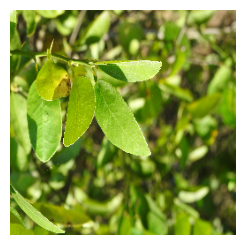

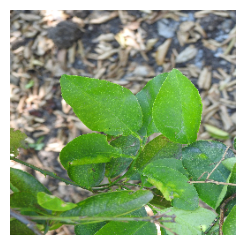

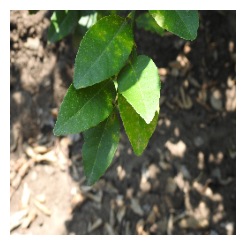

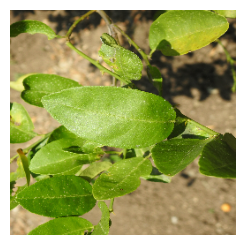

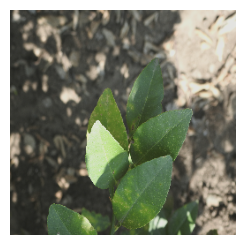

In [14]:
display_samples(healthy_ds, n_samples=5)

In [21]:
with strategy.scope():
    healthy_disease_generator = generator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE, transformer_blocks=TRANSFORMER_BLOCKS)
    disease_generator = generator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE, transformer_blocks=TRANSFORMER_BLOCKS)

    healthy_generator_optimizer = optimizers.Adam(learning_rate=GENERATOR_LR, beta_1=0.5)
    disease_generator_optimizer = optimizers.Adam(learning_rate=GENERATOR_LR, beta_1=0.5)


    healthy_discriminator = discriminator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE)
    disease_discriminator = discriminator_fn(height=HEIGHT_RESIZE, width=WIDTH_RESIZE)

    healthy_discriminator_optimizer = optimizers.Adam(learning_rate=DISCRIMINATOR_LR, beta_1=0.5)
    disease_discriminator_optimizer = optimizers.Adam(learning_rate=DISCRIMINATOR_LR, beta_1=0.5)

    gan_model = CycleGan(disease_generator, healthy_disease_generator, 
                         disease_discriminator, healthy_discriminator, 
                         'disease', 'healthy')
    

    gan_model.compile(f_gen_optimizer=disease_generator_optimizer,
                      s_gen_optimizer=healthy_generator_optimizer,
                      f_disc_optimizer=disease_discriminator_optimizer,
                      s_disc_optimizer=healthy_discriminator_optimizer,
                      gen_loss_fn=generator_loss,
                      disc_loss_fn=discriminator_loss,
                      cycle_loss_fn=calc_cycle_loss,
                      identity_loss_fn=identity_loss)


history = gan_model.fit(disease_healthy_ds, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        callbacks=[GANMonitor(disease_generator, 'disease')], 
                        steps_per_epoch=(126//BATCH_SIZE), 
                        verbose=2).history


healthy_disease_generator.save('healthy_disease_generator.h5')
disease_generator.save('disease_generator.h5')

Epoch 1/100


2023-06-22 19:47:00.497825: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-22 19:47:03.248984: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


7/7 - 287s - disease_gen_loss: 2.6583 - healthy_gen_loss: 3.0350 - disease_disc_loss: 1.2714 - healthy_disc_loss: 1.1349 - 287s/epoch - 41s/step
Epoch 2/100
7/7 - 3s - disease_gen_loss: 3.5945 - healthy_gen_loss: 3.5087 - disease_disc_loss: 1.4943 - healthy_disc_loss: 0.6913 - 3s/epoch - 417ms/step
Epoch 3/100
7/7 - 3s - disease_gen_loss: 3.3554 - healthy_gen_loss: 4.4576 - disease_disc_loss: 0.6162 - healthy_disc_loss: 0.6889 - 3s/epoch - 428ms/step
Epoch 4/100
7/7 - 3s - disease_gen_loss: 3.4982 - healthy_gen_loss: 3.3797 - disease_disc_loss: 0.6993 - healthy_disc_loss: 0.3864 - 3s/epoch - 403ms/step
Epoch 5/100
7/7 - 3s - disease_gen_loss: 3.3606 - healthy_gen_loss: 5.4369 - disease_disc_loss: 0.5846 - healthy_disc_loss: 0.0775 - 3s/epoch - 381ms/step
Epoch 6/100
7/7 - 3s - disease_gen_loss: 3.2359 - healthy_gen_loss: 4.5856 - disease_disc_loss: 0.4156 - healthy_disc_loss: 0.3168 - 3s/epoch - 399ms/step
Epoch 7/100
7/7 - 3s - disease_gen_loss: 5.3986 - healthy_gen_loss: 3.0942 - dis

In [18]:
create_gif('/kaggle/working/disease/*.png', 'disease.gif')

1/1 [==============================] - 1s 860ms/step


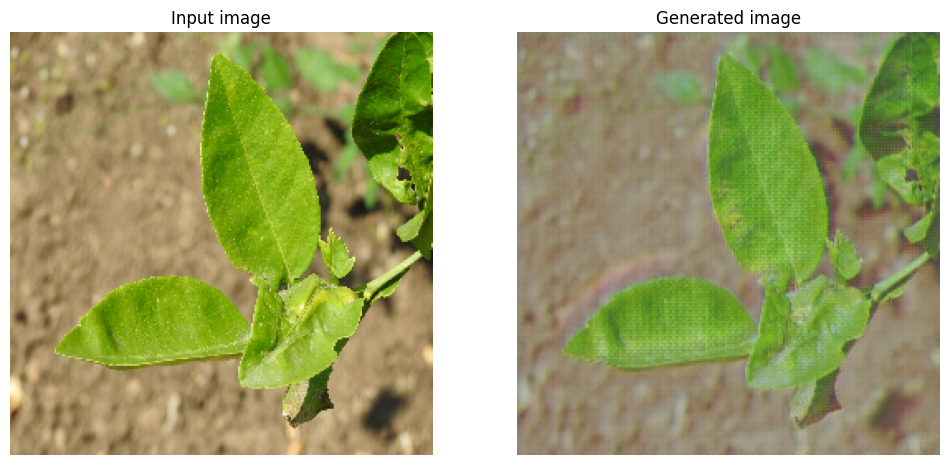

1/1 [==============================] - 1s 549ms/step


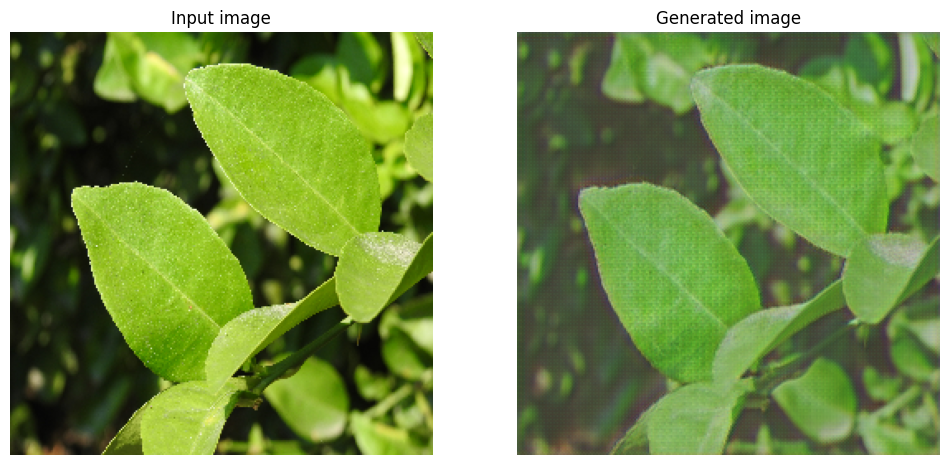

1/1 [==============================] - 1s 547ms/step


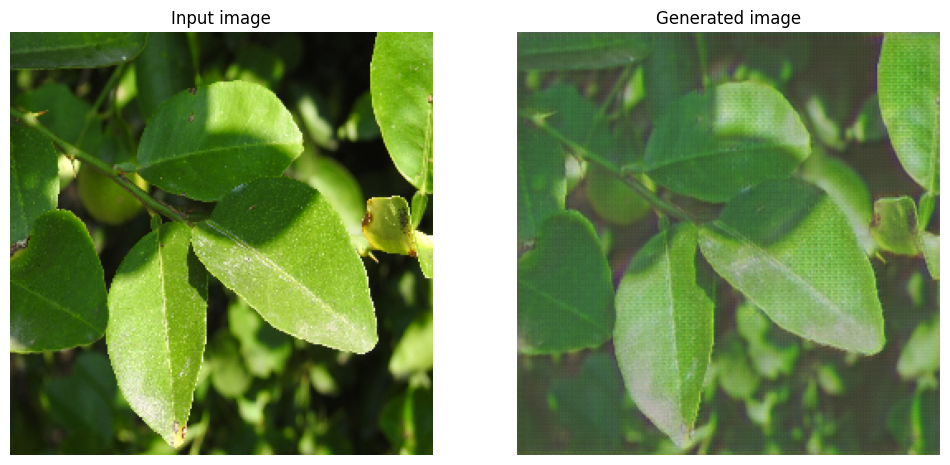

1/1 [==============================] - 1s 545ms/step


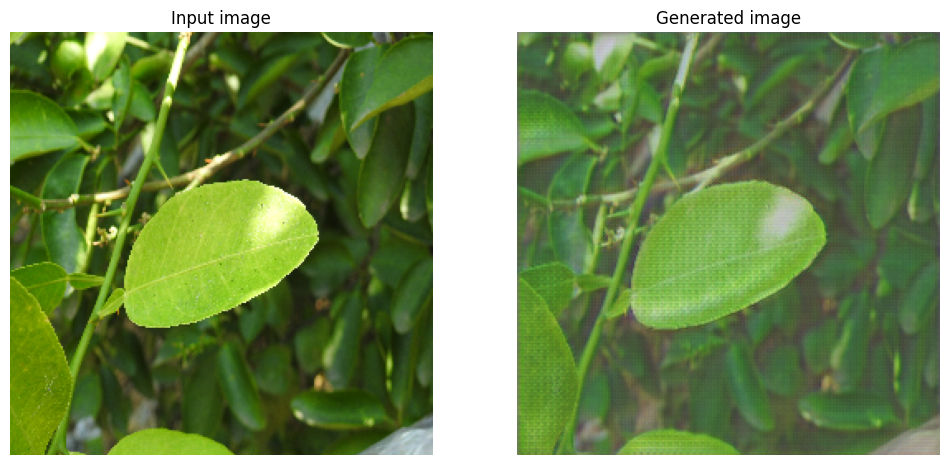

In [23]:
display_generated_samples(healthy_ds_eval.take(10), disease_generator, 4)

1/1 [==============================] - 1s 1s/step


2023-06-22 20:05:54.757711: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-06-22 20:05:54.860584: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


1/1 [==============================] - 1s 536ms/step


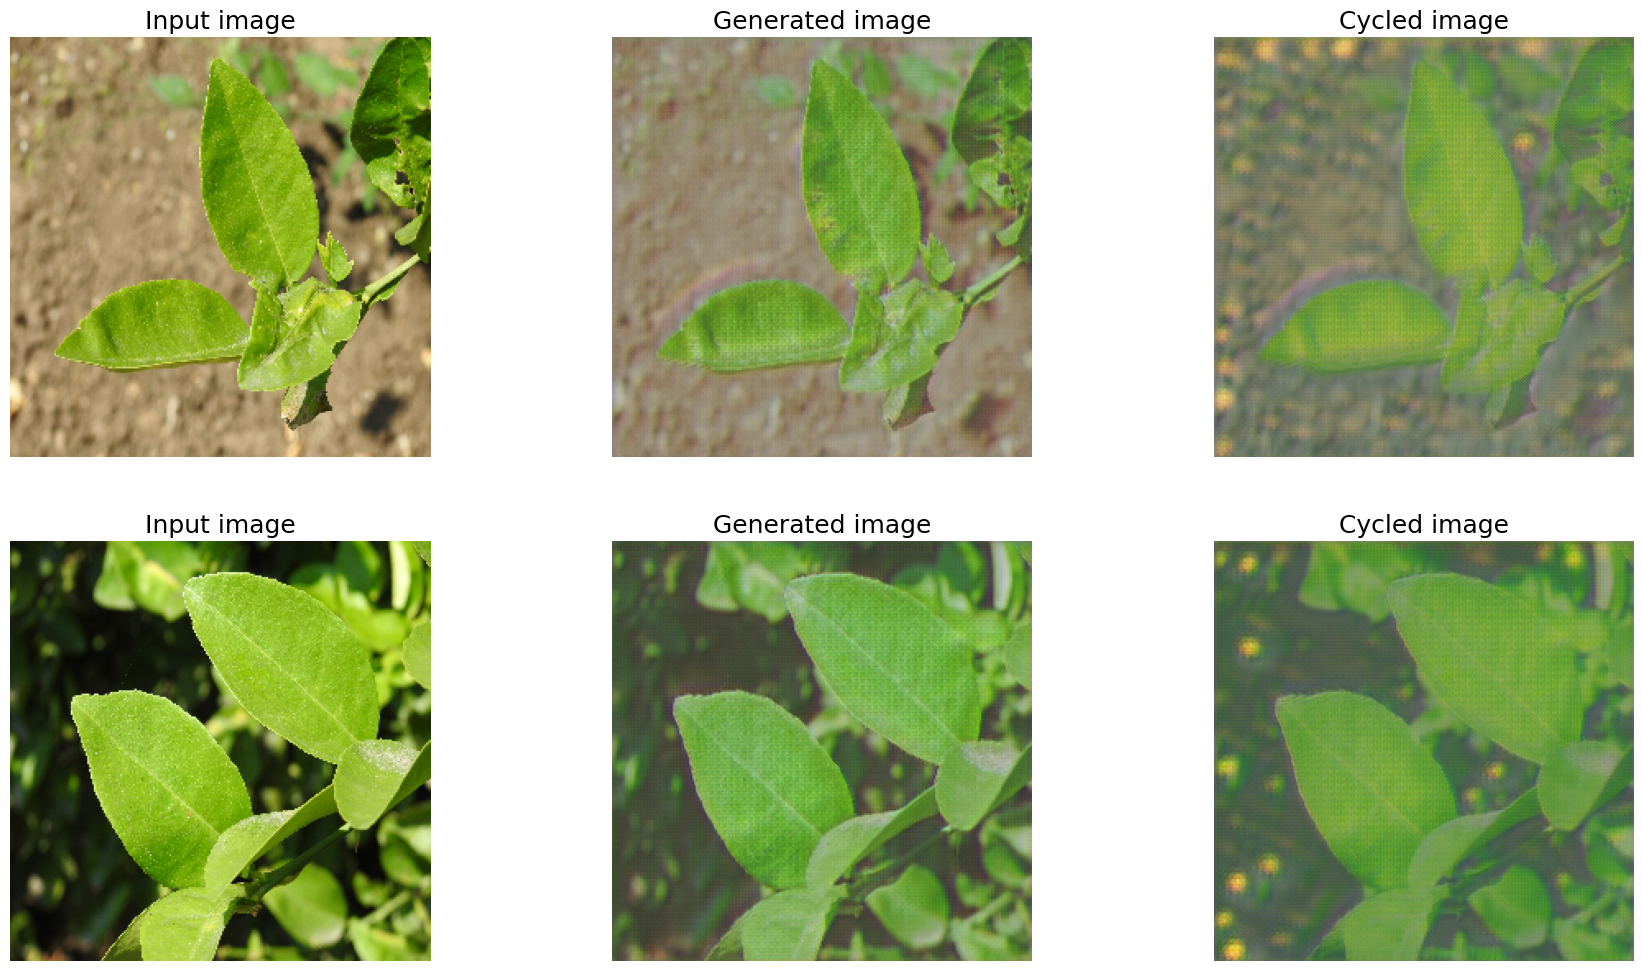

In [26]:
evaluate_cycle(healthy_ds_eval.take(2), disease_generator, healthy_disease_generator, n_samples=2)

1/1 [==============================] - 1s 853ms/step


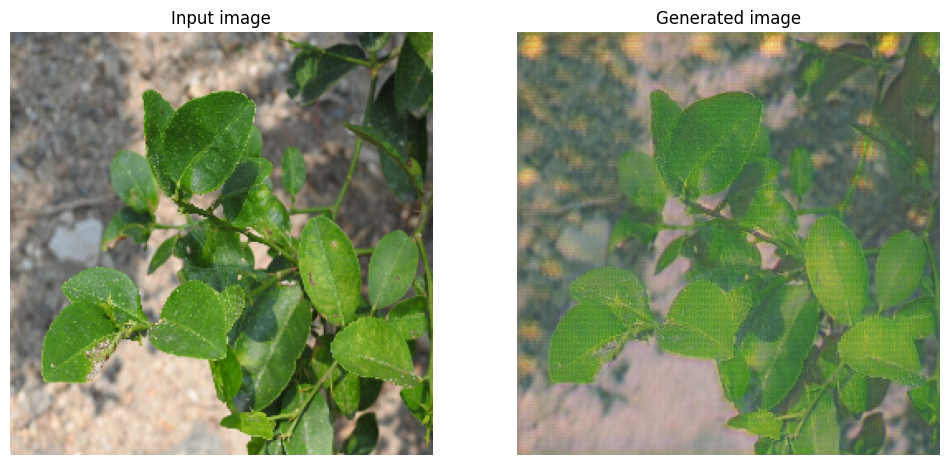

1/1 [==============================] - 1s 538ms/step


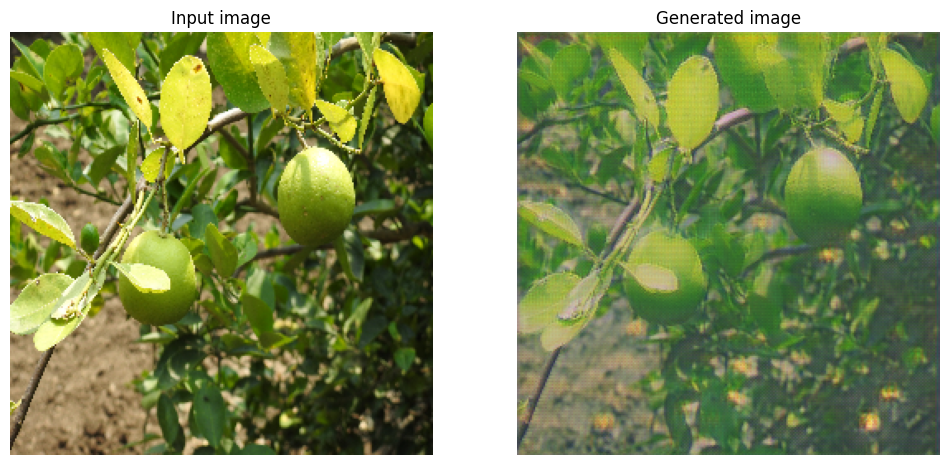

1/1 [==============================] - 1s 541ms/step


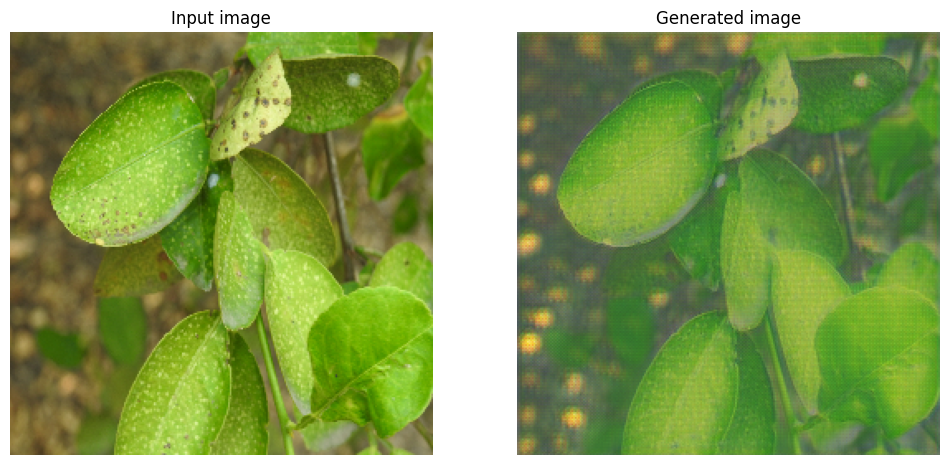

In [27]:
display_generated_samples(disease_ds_eval.take(3), healthy_disease_generator, 3)